## Hyperparameter Tuning (using Otto Group Product Data)

이번 과제는 머신러닝 모델의 Hyperparameter를 튜닝하여 예측모델을 만들어보겠습니다.
오늘 사용할 데이터는 세계 최대의 전자상거래 회사 중 하나인 [Otto Group](https://www.ottogroup.com/)에서 주최하는 [Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge/) 경진대회에서 제공하는 데이터입니다. 

<img src="https://drive.google.com/uc?export=download&id=1AhEKfkKPfe2Ju1UQa39vJn0r4k3Fgklx" width="640px" />

<center><small><a href="https://www.kaggle.com/c/otto-group-product-classification-challenge/">Otto Group Product Classification Challenge 경진대회</a></small></center>

<br />

Otto Group은 익명화(anonymization)된 상품 정보에 대한 데이터를 제공하는데, 경진대회 참석자는 이 데이터를 활용하여 주어진 상품 카테고리(target)를 예측해야 합니다. 상품 카테고리는 ```Class_1```부터 ```Class_9```까지 총 9개가 있습니다. 주어진 데이터를 의사결정나무(Decision Tree), 랜덤 포레스트(Random Forest), 그리고 그래디언트 부스팅 머신(Gradient Boosting Machine)를 활용하여 예측해보도록 하겠습니다.

### Prerequisites

경진대회에 참여하기에 앞서, 오늘 필요한 파이썬 패키지를 읽어오겠습니다. 가장 먼저 필요한 패키지는 파이썬에서 데이터를 분석하는데 도움을 주는 패키지 판다스([Pandas](https://pandas.pydata.org/)) 입니다. 이 패키지를 먼저 읽어오겠습니다.

In [1]:
# 파이썬에서 데이터를 분석해주는 패키지 판다스(Pandas)를 읽어옵니다.
# 이를 pd라는 축약어로 사용합니다.
import pandas as pd

### Load Dataset

예측모델을 만들기 위해선 먼저 데이터를 읽어와야 합니다.

모든 데이터 분석의 시작은 주어진 데이터를 읽어오는 것입니다. 판다스([Pandas](https://pandas.pydata.org/))에는 [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)라는 기능이 있는데, 이 기능을 활용하면 csv ([Comma Separated Values](https://en.wikipedia.org/wiki/Comma-separated_values)) 데이터를 편리하게 데이터를 읽어올 수 있습니다. ```read_csv```를 활용해 이 경진대회에서 제공하는 두 개의 데이터(train, test)를 읽어오겠습니다. (데이터는 [다음의 링크](https://www.kaggle.com/c/otto-group-product-classification-challenge/data)에서 다운받으실 수 있습니다)

여기서 파일의 경로를 지정하는 방법에 주의하셔야 합니다. 파일 경로 지정은 컴퓨터의 설정마다 천차만별로 다르기 때문에 사전에 컴퓨터의 경로 지정 개념을 숙지해두셔야 합니다. 만일 ```read_csv```를 실행할 때 ```FileNotFoundError```라는 에러가 난다면 경로가 제대로 지정이 되지 않은 것입니다. **만일 파일의 경로를 지정하는 법이 생각나지 않는다면 [다음의 링크](https://88240.tistory.com/122)를 통해 경로를 지정하는 법을 복습한 뒤 다시 시도해주세요.**

In [2]:
# 먼저 판다스(Pandas)를 활용해 test.csv 파일을 읽어옵니다.
# 여기에서 인덱스(index)로 train 데이터의 id 컬럼을 사용합니다.
# 그리고 읽어온 데이터를 train이라는 이름의 변수에 저장합니다.
train = pd.read_csv("data/train.csv", index_col="id")

# train 변수에 할당한 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(train.shape)

# head()로 train 데이터의 상위 5개를 띄웁니다.
train.head()

(61878, 94)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
4,1,0,0,1,6,1,5,0,0,1,...,0,1,2,0,0,0,0,0,0,Class_1
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


### Preprocessing

가장 먼저 해야 하는 준비는 데이터를 정리하는 것입니다. 데이터를 의사결정나무(Decision Tree), 랜덤 포레스트(Random Forest), 또는 그래디언트 부스팅 머신(Gradient Boosting Machine)과 같은 머신러닝 알고리즘에 넣기 위해서는, 사전에 데이터를 머신러닝 알고리즘이 이해할 수 있는 형태로 변환해줘야 합니다. 이 과정을 전문용어로 전처리(Preprocessing)라고 합니다.

오늘 학습할 머신러닝 알고리즘(내지는 지도학습(Supervised Learning) 알고리즘)에 데이터를 넣기 위해서는, 데이터를 두 가지 형태로 나눠줘야 합니다.

* **Label**: 레이블(Label), 내지는 타겟 변수(Target Variable)이라고 부릅니다. (몇몇 곳에서는 Class라고도 부릅니다) 쉽게 말해 우리가 맞춰야 하는 정답입니다.
* **Feature**: 우리가 label을 맞추는데 도움이 되는 값들입니다. 오늘 데이터에서는 label을 제외한 사실상 모든 컬럼들이 Feature가 될 수 있습니다.

이번 과제에서는 다음의 컬럼을 Feature와 Label로 활용할 것입니다.

* **Feature**: ```target``` 컬럼을 제외한 나머지 모든 컬럼
* **Label**: ```target``` 컬럼

위에서 언급한 방식 그대로 **Feature**와 **Label**을 만들어 보겠습니다.

In [3]:
# target이라는 이름의 컬럼을 label_name 이라는 이름의 변수에 할당합니다.
# 이 컬럼이 실질적으로 이번 경진대회의 Label이 됩니다.
label_name = "target"

# label_name 안에 들어있는 값을 출력하면, 예상대로 target이 출력되는것을 알 수 있습니다.
label_name

'target'

In [4]:
# label_name에 지정된 컬럼을 제외한 나머지 모든 컬럼을 Feature로 간주할 것입니다.
# 이를 feature_names라는 이름의 컬럼에 할당하겠습니다.
feature_names = train.columns.difference([label_name])

# feature_names의 길이(length, len)를 잽니다. 그리고 이를 바로 출력합니다.
# 전체 train 데이터의 컬럼 개수에서, target 컬럼 하나를 제외한 총 93개가 출력됩니다.
print(len(feature_names))

# feature_names 안에 들어가 있는 값의 상위 5개를 출력하면, Feature들의 몇몇 예시를 볼 수 있습니다.
feature_names[0:5]

93


Index(['feat_1', 'feat_10', 'feat_11', 'feat_12', 'feat_13'], dtype='object')

### Train


이제 본격적으로 학습에 들어가기 전, train 데이터를 feature와 label로 나눌 것입니다.

* ```X```: train 데이터의 feature 입니다. 
* ```y```: train 데이터의 label 입니다.

이제 앞서 지정한 feature와 label을 활용해 ```X```, ```y```을 각각 만들어 보겠습니다.

In [5]:
# feature_names를 활용해 train 데이터의 feature를 가져옵니다.
# 이를 X라는 이름의 변수에 할당합니다. 
X = train[feature_names]

# X 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(X.shape)

# X 데이터의 상위 5개를 띄웁니다.
X.head()

(61878, 93)


,feat_1,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_9,feat_90,feat_91,feat_92,feat_93
id,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,0,0,0,2,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,1,0,0,1,1,0,...,0,1,2,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,4,0,...,1,0,0,0,0,0,1,0,0,0


In [6]:
# label_name을 활용해 train 데이터의 label을 가져옵니다.
# 이를 y이라는 이름의 변수에 할당합니다.
y = train[label_name]

# unique 함수를 사용하여 y 안에 들어가 있는 값의 중복을 제거합니다.
# 이렇게 하면 y 안에 있는 값의 종류가 나오며, Class_1부터 Class_9까지 총 9개의 종류가 나옵니다.
# 이것을 Label의 종류, 앞으로는 클래스(Class)라고 부르겠습니다.
print(y.unique())

# y 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시될 것입니다.
print(y.shape)

# y 데이터의 상위 5개를 띄웁니다.
y.head()

['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']
(61878,)


id
1    Class_1
2    Class_1
3    Class_1
4    Class_1
5    Class_1
Name: target, dtype: object

## Use Decision Tree

X, y 데이터를 만들었으면, 이제 이 데이터를 활용하여 Decision Tree를 학습시켜 보겠습니다.

파이썬(Python) 프로그래밍 언어에서 인공지능&머신러닝에 관련된 기능을 가장 많이 보유하고 있는 건 [scikit-learn](scikit-learn.org) 입니다. scikit-learn에 있는 머신러닝 알고리즘에는 크게 두 가지 기능이 있습니다.


  * **fit**: 머신러닝 알고리즘을 학습시킵니다. 전문용어로 fitting한다고 하기 때문에 fit이라는 표현을 사용합니다.
  * **predict**: **fit**이 끝나면, 이후에 **predict**를 통해 예측을 할 수 있습니다. 

In [7]:
# scikit-learn(줄여서 sklearn)의 tree 모듈에서 DecisionTreeClassifier를 가져옵니다.
from sklearn.tree import DecisionTreeClassifier

# DecisionTreeClassifier를 생성하여 model이라는 이름의 변수에 할당합니다. 
# random_state는 의사결정나무의 결과가 랜덤하게 나오는 것을 고정하는 옵션입니다. 아무 숫자나 넣어주면 됩니다. (공학 용어에서 쓰이는 Seed Number와 동일한 개념입니다)
model = DecisionTreeClassifier(random_state = 42)

# model 변수 안에 들어가 있는 값을 출력합니다.
# DecisionTreeClassifier가 성공적으로 생성해서 model 변수에 할당되어 있는 사실을 알 수 있습니다.
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [8]:
# DecisionTreeClassifier를 학습(fitting)합니다.
# 학습에는 fit 이라는 기능을 사용하며, 학습시켜줄 데이터의 feature(X)와 label(y)을 집어넣습니다.
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [9]:
# fit이 끝났으면, predict라는 기능을 사용하여 상품 카테고리(Class)를 예측합니다.
# predict의 실행이 끝나면 상품 카테고리를 반환하며, 이를 y_predict라는 이름의 변수에 할당합니다.
y_predict = model.predict(X)
y_predict

array(['Class_1', 'Class_1', 'Class_1', ..., 'Class_9', 'Class_9',
       'Class_9'], dtype=object)

In [10]:
# 예측값(y_predict)이 얼마나 정답값(y)을 잘 맞췄는지 정확도를 계산합니다.
# 잘 맞췄으면 1, 못 맞췄으면 0 값을 주고 전체 데이터에 대해 평균을 계산하면 정확도(맞춘 비율)를 계산할 수 있습니다. 
accuracy = (y == y_predict).mean()
accuracy

1.0

### Hold-out Validation

한 번 학습을 시켜줬었던 데이터를 그대로 다시 넣어 예측을 했기 때문에, 예측 정확도가 1.0(100%)가 나왔습니다.

그럼 새로운 데이터(feature)가 주어졌을때, 제대로된 예측을 하고 있는지 혹은 이 모델의 정확도는 어느정도인지 알 수가 없습니다. 

따라서, 모델의 정확도를 평가하기 위해서는 가지고 있는 모든 데이터를 학습데이터(train)로 넣어주지 않고, train과 test데이터로 나누어 주어야합니다.

나누어준 후, train데이터로 학습을 시켜주고 test데이터로 모델의 성능을 측정합니다.

In [11]:
# scikit-learn의 model_selection 모듈에서 train_test_split 함수를 가져옵니다.
# 이 함수를 활용해서 Hold-out validation을 할 것입니다.
from sklearn.model_selection import train_test_split

# train_test_split 을 실행합니다. train 데이터, 정확히는 X와 y를 나눌 것이며,
# 비율은 학습용 데이터를 70%, 검증용 데이터를 30%로 나눌 것입니다.
# 이를 각각 X_train, X_test, y_train, y_test 라는 값으로 받습니다.
# (여기서 결과가 매 번 바뀌는 현상을 방지하기 위해, random_state를 사용해서 랜덤 값을 고정할 것입니다.)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3, random_state = 42)

# Train data와 Test data가 잘 나눠졌는지 각각의 데이터의 갯수를 출력하여 확인합니다.
# train데이터는 43314개, test데이터는 18564개입니다.
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

43314 43314
18564 18564


In [12]:
# DecisionTreeClassifier를 생성하여 model이라는 이름의 변수에 할당합니다. 
model = DecisionTreeClassifier(random_state = 42)

# model 변수 안에 들어가 있는 값을 출력합니다.
# DecisionTreeClassifier가 성공적으로 생성해서 model 변수에 할당되어 있는 사실을 알 수 있습니다.
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

이제, Train 데이터로 학습을 시켜줍니다. feature에는 ```X_train```, label에는 ```y_train```을 넣어줍니다. 

In [13]:
# DecisionTreeClassifier를 학습(fitting)합니다.
# 학습에는 fit 이라는 기능을 사용하며, train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

fitting이 끝났으면, 이제 test데이터를 이용하여 상품 카테고리를 predict(예측)하고, 얼마나 잘 맞췄는지 정확도(Accuracy)를 계산해봅니다.

In [14]:
# fit이 끝났으면, predict라는 기능을 사용하여 상품 카테고리(Class)를 예측합니다.
# X_train, X_test를 입력으로 예측한 결과를 각각 y_train_predict, y_test_predict라는 이름의 변수에 할당합니다.
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)


# 예측값(y_train_predict, y_test_predict)이 얼마나 정답값(y)을 잘 맞췄는지 정확도를 계산합니다.
# 잘 맞췄으면 1, 못 맞췄으면 0 값을 주고 전체 데이터에 대해 평균을 계산하면 정확도(맞춘 비율)를 계산할 수 있습니다. 
train_score = (y_train == y_train_predict).mean()
test_score = (y_test == y_test_predict).mean()

# train, test 데이터의 각각의 예측 정확도를 출력해봅니다.
# train데이터의 예측결과는 1.0, test데이터의 예측결과는 약 0.7XX 가 나옵니다.
f"train = {train_score:.6f}, test = {test_score:.6f}"

'train = 1.000000, test = 0.709869'

## Hyperparameter

이제, 모델(model)의 다양한 옵션(이하 **Hypterparameter**)을 조정해봅시다. 

sklearn의 **DecisionTreeClassifier**에서는 아래와 같은 다양한 옵션들 세팅할 수 있습니다.

* **max_depth**
* **min_samples_split**
* **min_samples_leaf**
* 이 외, DecisionTreeClassifier의 더욱 다양한 hyperparameter들에 대한 설명은 [이 곳 링크](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)에서 확인하실 수 있습니다.


각각의 **hyperparameter**가 어떤 특성을 가지고 있는지, 해당 **Hyperparameter**의 값에 따라 모델의 성능(정확도)가 어떻게 달라지는지 살펴보고자 합니다.

### Decision Tree - max_depth

가장 먼저, max_depth(나무의 최대 깊이)를 살펴보고자 합니다. 

* **max_depth** : 나무가 아래로 가지를 계속해서 칠 수 있는 나무의 최대 깊이. default 값은 None. ```max_depth```값이 None이면, 모든 잎(leaf)안의 데이터셋 개수가 ```min_samples_leaf```의 수보다 작아질 때까지 가지를 계속 칠 수 있습니다. 

```max_depth```(나무의 최대 깊이)가 커질수록 더 정교한 트리모델을 만들어 예측 정확도를 높일 수 있습니다. 하지만, 일정값을 넘어가면 train 데이터에 대한 overfitting이 발생하여 train데이터에 대한 정확도는 좋아질 수 있으나, test 데이터에 대한 정확도는 오히려 안 좋아질 수 있습니다. 

먼저 ```max_depth```를 30으로 지정한 새로운 모델을 만들어 학습을 시킨 후, train 데이터와 test 데이터에 대해 모델의 정확도를 측정해봅시다.

In [15]:
# DecisionTreeClassifier를 생성하여 model이라는 이름의 변수에 할당합니다. 
# max_depth(나무의 최대 깊이)를 30으로 지정해줍니다.
model = DecisionTreeClassifier(max_depth = 30, random_state = 42)

# DecisionTreeClassifier를 학습(fitting)합니다. train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
model.fit(X_train, y_train)

# X_train, X_test를 입력으로 predict(예측)한 결과를 각각 y_train_predict, y_test_predict라는 이름의 변수에 할당합니다.
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

# 예측값(y_train_predict, y_test_predict)이 얼마나 정답값(y)을 잘 맞췄는지 정확도를 계산합니다.
train_score = (y_train == y_train_predict).mean()
test_score = (y_test == y_test_predict).mean()

# train, test 데이터의 각각의 예측 정확도를 출력해봅니다.
f"train = {train_score:.6f}, test = {test_score:.6f}"

'train = 0.937434, test = 0.719242'

```max_depth``` 값을 제한해주었기 때문에, train 데이터에 대한 정확도는 1이 아닌 0.9XX가 나오고 test 데이터에 대한 정확도는 조금 높아졌습니다.

이제, ```max_depth```의 값에 따라 정확도가 어떻게 변하는지 확인해봅시다.

In [16]:
# range함수를 이용하여 max_depth_list에 2부터 50까지 자연수를 생성합니다.
max_depth_list = range(2, 51)

# 각각의 max_depth에 따른 결과를 저장하기 위한 리스트(history)를 만듭니다.
history = []

# max_depth_list에 있는 숫자만큼 돌릴 for문을 선언합니다.
for max_depth in max_depth_list:

    # DecisionTreeClassifier를 생성하여 model이라는 이름의 변수에 할당합니다. 
    # max_depth(나무의 최대 깊이)를 max_depth로 지정해줍니다.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = 42)
    
    # 생성한 model을 학습(fitting)합니다. train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
    model.fit(X_train, y_train)
    
    # X_train, X_test를 입력으로 predict(예측)한 결과를 각각 y_train_predict, y_test_predict라는 이름의 변수에 할당합니다.
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    # 예측값(y_train_predict, y_test_predict)이 얼마나 정답값(y)을 잘 맞췄는지 정확도를 계산합니다.
    train_score = (y_train == y_train_predict).mean()
    test_score = (y_test == y_test_predict).mean()
    
    # max_depth에 따른 train, test 데이터의 각각의 예측 정확도를 출력해봅니다.
    print(f"max_depth = {max_depth}, train = {train_score:.6f}, test = {test_score:.6f}")
    
    # max_depth에 따른 train, test 데이터에 대한 예측 정확도를 history에 저장합니다.
    history.append({
        'max_depth': max_depth,
        'train': train_score,
        'test': test_score,
    })

# 결과를 판다스의 DataFrame형태로 변형하여 출력합니다.
history = pd.DataFrame(history)
history

max_depth = 2, train = 0.439950, test = 0.438160
max_depth = 3, train = 0.477375, test = 0.477537
max_depth = 4, train = 0.527982, test = 0.524402
max_depth = 5, train = 0.529090, test = 0.525479
max_depth = 6, train = 0.558849, test = 0.555591
max_depth = 7, train = 0.568638, test = 0.570297
max_depth = 8, train = 0.605301, test = 0.599224
max_depth = 9, train = 0.634345, test = 0.628528
max_depth = 10, train = 0.660895, test = 0.652984
max_depth = 11, train = 0.676964, test = 0.662034
max_depth = 12, train = 0.691855, test = 0.672969
max_depth = 13, train = 0.716720, test = 0.690853
max_depth = 14, train = 0.733019, test = 0.699580
max_depth = 15, train = 0.747079, test = 0.701896
max_depth = 16, train = 0.763772, test = 0.705882
max_depth = 17, train = 0.780094, test = 0.713963
max_depth = 18, train = 0.795239, test = 0.715956
max_depth = 19, train = 0.810269, test = 0.716171
max_depth = 20, train = 0.824445, test = 0.717787
max_depth = 21, train = 0.839313, test = 0.722474
max_dept

,max_depth,train,test
0,2,0.439950,0.438160
1,3,0.477375,0.477537
2,4,0.527982,0.524402
3,5,0.529090,0.525479
4,6,0.558849,0.555591
5,7,0.568638,0.570297
6,8,0.605301,0.599224
7,9,0.634345,0.628528
8,10,0.660895,0.652984
9,11,0.676964,0.662034


이제, ```max_depth```에 따른 학습결과(정확도)를 시각화 해봅시다.

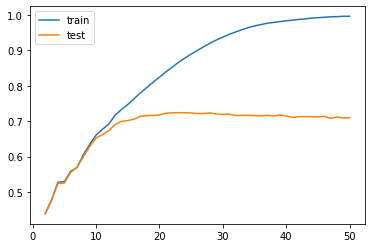

In [17]:
# 주피터 노트북에서 그림을 바로 띄워주도록 합니다. 
%matplotlib inline
# 학습결과를 그래프로 그려주는 matplotlib의 pyplot모듈을 불러옵니다.
import matplotlib.pyplot as plt

# pyplot의 plot으로 x축에는 max_depth값을 y축에는 train,test데이터에 대한 모델의 예측정확도값을 넣어줍니다.
plt.plot(history['max_depth'], history['train'], label='train')
plt.plot(history['max_depth'], history['test'], label='test')

# 범례를 출력합니다.
plt.legend()

초반에는 ```max_depth```가 커질수록 train, test데이터에 대한 모델의 정확도가 함께 증가하지만, 일정값(약 10)을 지나면서 test데이터에 대한 정확도는 train 데이터의 정확도만큼 증가하지 못하고, 약 20을 넘어가면서부터는 오히려 test 데이터에 대한 정확도가 조금씩 감소하는 overfitting이 발생함을 확인할 수 있습니다. 

### Decision Tree - min_samples_split

* **min_samples_split** : 가지를 칠 수 있는 최소한의 데이터셋 개수. default 값은 2. 잎(leaf) 안에 있는 데이터셋의 개수가 ```min_samples_split``` 보다 적을 경우, 더 이상 가지를 칠 수 없습니다.    

```min_samples_split``` 값은 작을수록 더 많은 가지를 칠 수 있으니 좀 더 정교한 모델을 만들 수 있습니다. 하지만, 일정 값 이하로 너무 작아지면 마찬가지로 overfitting이 발생할 수 있습니다.

이제, ```min_samples_split```(가지를 칠 수 있는 최소한의 데이터셋 개수)값을 변화시켜주면서, ```min_samples_split``` 값에 따라 정확도가 어떻게 변하는지 확인해봅시다.

In [18]:
# range함수를 이용하여 min_samples_split_list에 10부터 300까지 10단위로 자연수를 생성합니다.
min_samples_split_list = range(10, 301, 10)

# 각각의 min_samples_split에 따른 결과를 저장하기 위한 리스트(history)를 만듭니다.
history = []

# min_samples_split_list에 있는 숫자만큼 돌릴 for문을 선언합니다.
for min_samples_split in min_samples_split_list:

    # DecisionTreeClassifier를 생성하여 model이라는 이름의 변수에 할당합니다. 
    # min_samples_split(가지를 칠 수 있는 최소한의 데이터셋 개수)를 min_samples_split로 지정해줍니다.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = 42)
    
    # 생성한 model을 학습(fitting)합니다. train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
    model.fit(X_train, y_train)
    
    # X_train, X_test를 입력으로 predict(예측)한 결과를 각각 y_train_predict, y_test_predict라는 이름의 변수에 할당합니다.
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    # 예측값(y_train_predict, y_test_predict)이 얼마나 정답값(y)을 잘 맞췄는지 정확도를 계산합니다.
    train_score = (y_train == y_train_predict).mean()
    test_score = (y_test == y_test_predict).mean()
    
    # min_samples_split에 따른 train, test 데이터의 각각의 예측 정확도를 출력해봅니다.
    print(f"min_samples_split = {min_samples_split}, train = {train_score:.6f}, test = {test_score:.6f}")
    
    # min_samples_split에 따른 train, test 데이터에 대한 예측 정확도를 history에 저장합니다.
    history.append({
        'min_samples_split': min_samples_split,
        'train': train_score,
        'test': test_score,
    })

# 결과를 판다스의 DataFrame형태로 변형하여 출력합니다.
history = pd.DataFrame(history)
history

min_samples_split = 10, train = 0.911738, test = 0.713801
min_samples_split = 20, train = 0.866879, test = 0.715309
min_samples_split = 30, train = 0.842545, test = 0.714717
min_samples_split = 40, train = 0.825484, test = 0.717679
min_samples_split = 50, train = 0.812301, test = 0.716009
min_samples_split = 60, train = 0.803343, test = 0.716225
min_samples_split = 70, train = 0.794454, test = 0.717087
min_samples_split = 80, train = 0.788821, test = 0.717572
min_samples_split = 90, train = 0.784481, test = 0.720750
min_samples_split = 100, train = 0.779586, test = 0.720642
min_samples_split = 110, train = 0.776216, test = 0.720642
min_samples_split = 120, train = 0.772660, test = 0.720265
min_samples_split = 130, train = 0.768966, test = 0.720480
min_samples_split = 140, train = 0.767142, test = 0.719942
min_samples_split = 150, train = 0.764649, test = 0.719080
min_samples_split = 160, train = 0.761001, test = 0.718003
min_samples_split = 170, train = 0.758623, test = 0.718326
min_sa

,min_samples_split,train,test
0,10,0.911738,0.713801
1,20,0.866879,0.715309
2,30,0.842545,0.714717
3,40,0.825484,0.717679
4,50,0.812301,0.716009
5,60,0.803343,0.716225
6,70,0.794454,0.717087
7,80,0.788821,0.717572
8,90,0.784481,0.720750
9,100,0.779586,0.720642


이제, ```min_samples_split```에 따른 학습결과(정확도)를 시각화 해봅시다.

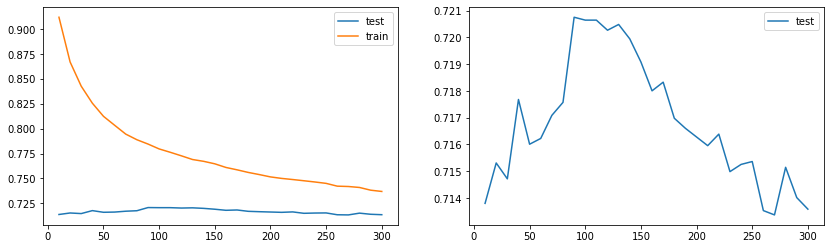

In [19]:
# 주피터 노트북에서 그림을 바로 띄워주도록 합니다. 
%matplotlib inline
# 학습결과를 그래프로 그려주는 matplotlib의 pyplot모듈을 불러옵니다.
import matplotlib.pyplot as plt

# 그래프의 크기를 설정합니다. 가로 14, 세로 4
plt.figure(figsize = (14, 4))

# pyplot의 plot으로 x축에는 min_samples_split값을 y축에는 train,test데이터에 대한 모델의 예측정확도값을 넣어줍니다.
# nrows=1, ncols=2인 서브플롯에서 첫번째 위치에 그래프를 그립니다.
plt.subplot(1,2,1)
plt.plot(history['min_samples_split'], history['test'], label='test')
plt.plot(history['min_samples_split'], history['train'], label='train')
# 범례를 출력합니다. 
plt.legend()

# test데이터에 대한 모델의 예측정확도 값만 따로 그려줍니다.
# nrows=1, ncols=2인 서브플롯에서 두번째 위치에 그래프를 그립니다.
plt.subplot(1,2,2)
plt.plot(history['min_samples_split'], history['test'], label='test')

# 범례를 출력합니다.
plt.legend()

min_samples_split이 작을수록 train 에 대한 모델의 정확도는 증가하지만, test 데이터에서의 경우 overfitting이 발생하여 오히려 정확도가 낮아집니다. **약 100~150 사이**에서 test데이터에 대한 모델의 정확도가 가장 높게 나옵니다. 

### Decision Tree - min_samples_leaf

* **min_samples_leaf** : 트리의 잎(leaf)안에 존재할 수 있는 최소한의 데이터셋 개수. default 값은 1. 가지를 칠 때, 각각의 잎(leaf)에 속하게 될 데이터셋의 개수가 ```min_samples_leaf``` 보다 작을 경우 더 이상 가지를 칠 수 없습니다. 


```min_samples_leaf``` 값도 마찬가지로 더 작을수록 더 많은 가지를 칠 수 있으니 좀 더 정교한 모델을 만들 수 있습니다. 하지만, 일정 값 이하로 너무 작아지면 마찬가지로 overfitting이 발생할 수 있습니다.

이제, ```min_samples_leaf```(가지를 칠 수 있는 최소한의 데이터셋 개수)값을 변화시켜주면서, ```min_samples_split``` 값에 따라 정확도가 어떻게 변하는지 확인해봅시다.

In [20]:
# range함수를 이용하여 min_samples_leaf_list에 1부터 100까지 2단위로 자연수를 생성합니다.
min_samples_leaf_list = range(1, 101, 2)

# 각각의 min_samples_leaf에 따른 결과를 저장하기 위한 리스트(history)를 만듭니다.
history = []

# min_samples_leaf_list에 있는 숫자만큼 돌릴 for문을 선언합니다.
for min_samples_leaf in min_samples_leaf_list:

    # DecisionTreeClassifier를 생성하여 model이라는 이름의 변수에 할당합니다. 
    # min_samples_leaf(나무의 최대 깊이)를 min_samples_leaf로 지정해줍니다.
    model = DecisionTreeClassifier(min_samples_leaf = min_samples_leaf,
                                   random_state = 42)
    
    # 생성한 model을 학습(fitting)합니다. train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
    model.fit(X_train, y_train)
    
    # X_train, X_test를 입력으로 predict(예측)한 결과를 각각 y_train_predict, y_test_predict라는 이름의 변수에 할당합니다.
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    # 예측값(y_train_predict, y_test_predict)이 얼마나 정답값(y)을 잘 맞췄는지 정확도를 계산합니다.
    train_score = (y_train == y_train_predict).mean()
    test_score = (y_test == y_test_predict).mean()
    
    # min_samples_leaf에 따른 train, test 데이터의 각각의 예측 정확도를 출력해봅니다.
    print(f"min_samples_leaf = {min_samples_leaf}, train = {train_score:.6f}, test = {test_score:.6f}")
    
    # min_samples_leaf에 따른 train, test 데이터에 대한 예측 정확도를 history에 저장합니다.
    history.append({
        'min_samples_leaf': min_samples_leaf,
        'train': train_score,
        'test': test_score,
    })

# 결과를 판다스의 DataFrame형태로 변형하여 출력합니다.
history = pd.DataFrame(history)
history

min_samples_leaf = 1, train = 1.000000, test = 0.709869
min_samples_leaf = 3, train = 0.898716, test = 0.712346
min_samples_leaf = 5, train = 0.854158, test = 0.713208
min_samples_leaf = 7, train = 0.827723, test = 0.719242
min_samples_leaf = 9, train = 0.811562, test = 0.719565
min_samples_leaf = 11, train = 0.799972, test = 0.719080
min_samples_leaf = 13, train = 0.789006, test = 0.718056
min_samples_leaf = 15, train = 0.781133, test = 0.720373
min_samples_leaf = 17, train = 0.773791, test = 0.718864
min_samples_leaf = 19, train = 0.768043, test = 0.717787
min_samples_leaf = 21, train = 0.762617, test = 0.719672
min_samples_leaf = 23, train = 0.758323, test = 0.717572
min_samples_leaf = 25, train = 0.755091, test = 0.715902
min_samples_leaf = 27, train = 0.751697, test = 0.715740
min_samples_leaf = 29, train = 0.747472, test = 0.714986
min_samples_leaf = 31, train = 0.745440, test = 0.713478
min_samples_leaf = 33, train = 0.742947, test = 0.715471
min_samples_leaf = 35, train = 0.740

,min_samples_leaf,train,test
0,1,1.000000,0.709869
1,3,0.898716,0.712346
2,5,0.854158,0.713208
3,7,0.827723,0.719242
4,9,0.811562,0.719565
5,11,0.799972,0.719080
6,13,0.789006,0.718056
7,15,0.781133,0.720373
8,17,0.773791,0.718864
9,19,0.768043,0.717787


이제, ```min_samples_leaf```에 따른 학습결과(정확도)를 시각화 해봅시다.

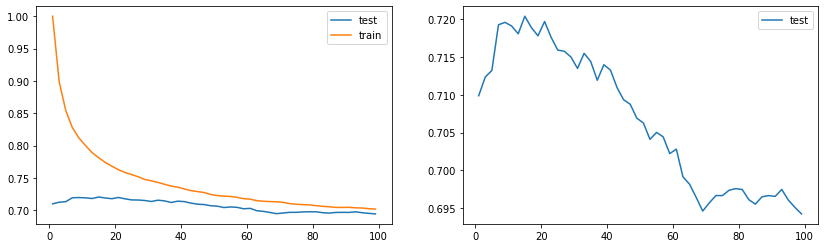

In [21]:
# 주피터 노트북에서 그림을 바로 띄워주도록 합니다. 
%matplotlib inline
# 학습결과를 그래프로 그려주는 matplotlib의 pyplot모듈을 불러옵니다.
import matplotlib.pyplot as plt

# 그래프의 크기를 설정합니다. 가로 14, 세로 4
plt.figure(figsize = (14, 4))

# pyplot의 plot으로 x축에는 min_samples_leaf값을 y축에는 train,test데이터에 대한 모델의 예측정확도값을 넣어줍니다.
# nrows=1, ncols=2인 서브플롯에서 첫번째 위치에 그래프를 그립니다.
plt.subplot(1,2,1)
plt.plot(history['min_samples_leaf'], history['test'], label='test')
plt.plot(history['min_samples_leaf'], history['train'], label='train')
# 범례를 출력합니다. 
plt.legend()

# test데이터에 대한 모델의 예측정확도 값만 따로 그려줍니다.
# nrows=1, ncols=2인 서브플롯에서 두번째 위치에 그래프를 그립니다.
plt.subplot(1,2,2)
plt.plot(history['min_samples_leaf'], history['test'], label='test')

# 범례를 출력합니다.
plt.legend()

```min_samples_leaf```이 작을수록 train 에 대한 모델의 정확도는 증가하지만, test 데이터에서의 경우 overfitting이 발생하여 오히려 정확도가 낮아집니다. **약 7~21 사이**에서 test데이터에 대한 모델의 정확도가 가장 높게 나옵니다. 

* 이 외, DecisionTreeClassifier의 더욱 다양한 hyperparameter들에 대한 설명은 [이 곳 링크](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)에서 확인하실 수 있습니다.